### Set-up for training 

In [1]:
# Import some common libraries
import torch
import numpy as np
import os, json, random, cv2, time

# Setup detectron2 
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import utilities for visualizing annotations
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
# Import utilities for training
from detectron2 import model_zoo
from detectron2.config import get_cfg
# Import utilities for custom hooks
from detectron2.data import build_detection_train_loader
from detectron2.engine import HookBase, DefaultTrainer
from detectron2.engine.hooks import PeriodicWriter
import detectron2.utils.comm as comm

### Create DatasetCatalog from parsed datasets

In [2]:
# Load serialized datasets
datasets_dict = {}

for d in (["train", "val"]):    
    with open("dataset_dict_" + d + ".json") as f:
        datasets_dict[d] = json.load(f)
        
# Define function that returns corresponding list of dicts
def return_dataset(keyword):
    for key in datasets_dict:
        if key == keyword:
            return datasets_dict[key]

In [3]:
# Register datasets in DatasetCatalog
DatasetCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("dataset_" + d, lambda d=d: return_dataset(d))
    MetadataCatalog.get("dataset_" + d).set(thing_classes=["robot_arm", "box"], 
                                        keypoint_names=["base", "joint_1", "joint_2", "tip", 
                                                        "top_front_left", "top_front_right", "top_back_left", "top_back_right"],
                                                # images are flipped in training process, so reeavulate!
                                        keypoint_flip_map=[("top_front_left", "top_front_right"), ("top_back_left", "top_back_right")],
                                        keypoint_connection_rules=[("base", "joint_1", (255,0,0)),
                                                                   ("joint_1", "joint_2", (0,255,0)),
                                                                   ("joint_2", "tip", (0,0,255)),
                                                                   ("top_front_left", "top_front_right", (255, 0, 0)),
                                                                   ("top_front_left", "top_back_left", (0, 255, 0)),
                                                                   ("top_back_left", "top_back_right", (0, 0, 255)),
                                                                   ("top_front_right", "top_back_right", (255, 255, 0))])

### Visualize annotations of parsed data

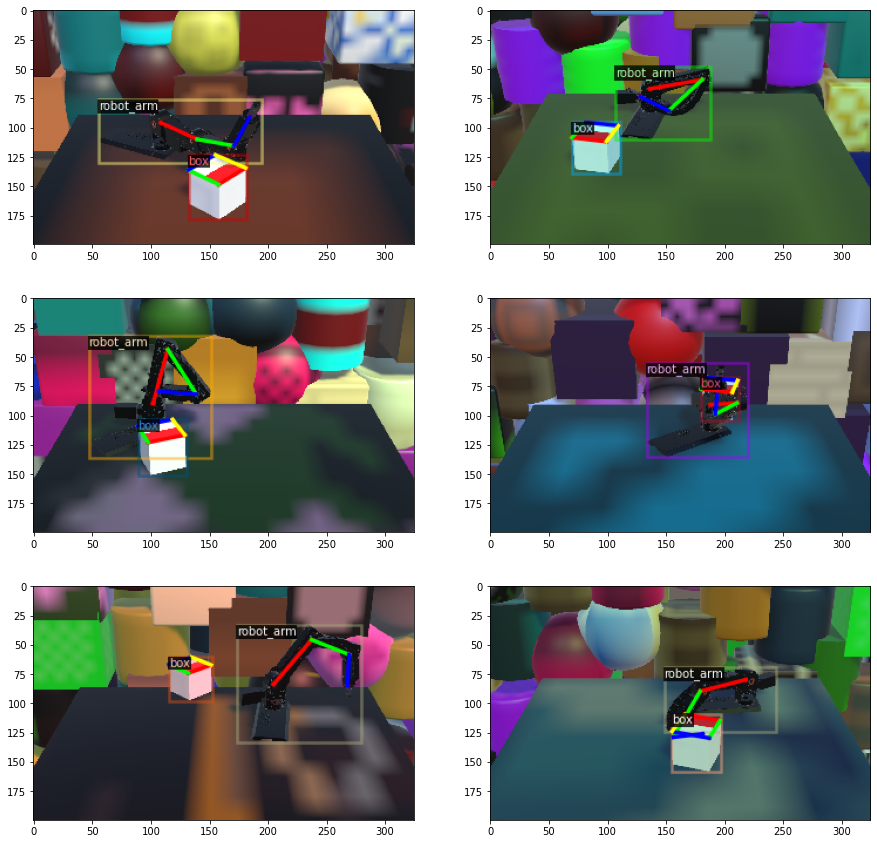

In [4]:
import matplotlib.pyplot as plt

# Get dataeset and metadata for visualization
demo_metadata = MetadataCatalog.get("dataset_train")
demo_dataset = return_dataset("train")

# Plot annotated images
fig = plt.figure(figsize=(15, 15))

for idx, d in enumerate(random.sample(demo_dataset, 6)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=demo_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    fig.add_subplot(3, 2, idx+1)
    plt.imshow(out.get_image())
                 
plt.show()

### Define custom trainer, validation hook and set parameters

In [5]:
import copy
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data import DatasetMapper
from fvcore.transforms.transform import BlendTransform

class MyRandomNoise(T.Augmentation):                          
    def __init__(self, std_min, std_max):
        """
        Args:
            std_min (in): Minimum standard deviation
            std_max (int): Maximum standard deviation
        """
        super().__init__()
        self._init(locals())
                          
    def get_transform(self, image):
        return MyNoiseTransform(self.std_min, self.std_max)
    
class MyNoiseTransform(T.Transform):                          
    def __init__(self, std_min, std_max):
        """
        Args:
            noise (ndarray): Random noise sample
        """
        super().__init__()
        self._set_attributes(locals())

    def apply_image(self, image):
        mean = 0
        std = np.random.randint(self.std_min, self.std_max)
        sigma = std**0.5
        noise = np.random.normal(mean, sigma, (image.shape))
        n_img = image + noise.reshape(image.shape)
        return n_img.astype(np.uint8)
    
    def apply_coords(self, coords):
        """
        Apply no transform on the coordinates.
        """
        return coords

    def apply_segmentation(self, segmentation):
        """
        Apply no transform on the full-image segmentation.
        """
        return segmentation
    
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # return build_detection_train_loader(cfg, mapper=custom_mapper)
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, is_train=True, 
                                                                      augmentations=[T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, "choice"),
                                                                                     T.RandomFlip(),
                                                                                     T.RandomContrast(0.5, 1.5),
                                                                                     T.RandomBrightness(0.5, 1.5),
                                                                                     T.RandomSaturation(0.5, 1.5),
                                                                                     MyRandomNoise(10, 50)] ))                                                                      

In [6]:
# Write custom hook to compute validation loss during training

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        self.num_steps = 0
      
    def after_step(self):
        self.num_steps += 1
        if self.num_steps % (iterations//epochs) == 0:
            print("ValidationLoss Hook now executing ...")
            data = next(self._loader)
            with torch.no_grad():
                loss_dict = self.trainer.model(data)

                losses = sum(loss_dict.values())
                assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                  comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                    **loss_dict_reduced)

        else:
            pass

In [7]:
# Define and set parameters
dataset_train = ("dataset_train",)
dataset_val = ("dataset_val",)

oks_sigmas = np.ones((8, 1), dtype=float).tolist()
mini_batch_size = 2
roi_batch_size = 512
iterations_per_epoch = len(return_dataset("train")) // mini_batch_size # for single GPU training
epochs = 20 #for more epochs _C.SOLVER.MAX_ITER needs to be increased (default: 40000)
iterations = iterations_per_epoch * epochs
coco_interval = iterations // 5 
lr = 0.0025 # = with reference to: good_lr = 0.02 * batch_size / 16
gamma = 10

# import fractions
# f1 = fractions.Fraction(2,3)
# f2 = fractions.Fraction(8,9)
# iters_lowered_lr = (int(iterations*f1), int(iterations*f2),) # use same ratio as in papers for lr decay

iou_thresholds = [0.5] # RoIs are considered positive with overlap of at least 0.5
# default for MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5]
positive_ratio = 0.33 # approx 1:3 positives to negatives
nms_threshold = 0.5 # default for MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
props_train = 2000
props_test = 1000 # for FPN backbone

In [8]:
print(iterations_per_epoch, iterations)

400 8000


### Train model from model_zoo

In [9]:
# Define config-file for parameters and settings
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = dataset_train
cfg.DATASETS.VAL = dataset_val
cfg.DATASETS.TEST = ()
cfg.SOLVER.BASE_LR = lr  
cfg.SOLVER.GAMMA = 0.1 # default
cfg.SOLVER.STEPS = (30000,) # default
cfg.SOLVER.MAX_ITER = iterations

cfg.DATALOADER.NUM_WORKERS = 2    
cfg.SOLVER.IMS_PER_BATCH = mini_batch_size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = roi_batch_size
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = positive_ratio
cfg.INPUT.RANDOM_FLIP = "horizontal" # default
cfg.INPUT.FORMAT = "BGR" # the models in d2 are trained on this image format
cfg.MODEL.BACKBONE.FREEZE_AT = 2 # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 8
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = props_train
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = props_test
cfg.TEST.KEYPOINT_OKS_SIGMAS = oks_sigmas

# set up trainer and register custom hook
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) #DefaultTrainer(cfg) 
trainer.register_hooks(
    [ValidationLoss(cfg)]
)

# change Hook order so that PeriodicWriter is the last one
periodic_writer_hook = [hook for hook in trainer._hooks if isinstance(hook, PeriodicWriter)]
all_other_hooks = [hook for hook in trainer._hooks if not isinstance(hook, PeriodicWriter)]
trainer._hooks = all_other_hooks + periodic_writer_hook

trainer.resume_or_load(resume=False)
trainer.train()

[06/10 13:23:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 8, 4, 4) i

[06/10 13:23:08 d2.engine.train_loop]: Starting training from iteration 0


/opt/miniconda3/envs/d2/lib/python3.7/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/miniconda3/envs/d2/lib/python3.7/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/miniconda3/envs/d2/lib/python3.7/site-packages/dete

[06/10 13:23:16 d2.utils.events]:  eta: 0:47:12  iter: 19  total_loss: 9.461  loss_cls: 1.028  loss_box_reg: 0.1193  loss_keypoint: 8.115  loss_rpn_cls: 0.1897  loss_rpn_loc: 0.02082  time: 0.3585  data_time: 0.0169  lr: 4.9952e-05  max_mem: 2881M
[06/10 13:23:23 d2.utils.events]:  eta: 0:47:41  iter: 39  total_loss: 9.017  loss_cls: 0.6307  loss_box_reg: 0.1555  loss_keypoint: 8.051  loss_rpn_cls: 0.1077  loss_rpn_loc: 0.0166  time: 0.3607  data_time: 0.0039  lr: 9.9902e-05  max_mem: 2881M
[06/10 13:23:30 d2.utils.events]:  eta: 0:48:10  iter: 59  total_loss: 8.571  loss_cls: 0.3185  loss_box_reg: 0.1752  loss_keypoint: 8.003  loss_rpn_cls: 0.06992  loss_rpn_loc: 0.01589  time: 0.3668  data_time: 0.0043  lr: 0.00014985  max_mem: 2881M
[06/10 13:23:38 d2.utils.events]:  eta: 0:47:54  iter: 79  total_loss: 8.436  loss_cls: 0.2436  loss_box_reg: 0.1892  loss_keypoint: 7.923  loss_rpn_cls: 0.04716  loss_rpn_loc: 0.01969  time: 0.3683  data_time: 0.0044  lr: 0.0001998  max_mem: 2881M
[06/1

/opt/miniconda3/envs/d2/lib/python3.7/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/opt/miniconda3/envs/d2/lib/python3.7/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)


[06/10 13:25:45 d2.utils.events]:  eta: 0:49:25  iter: 399  total_loss: 3.384  loss_cls: 0.07576  loss_box_reg: 0.1283  loss_keypoint: 3.174  loss_rpn_cls: 0.005584  loss_rpn_loc: 0.009505  total_val_loss: 2.599  val_loss_cls: 0.1103  val_loss_box_reg: 0.11  val_loss_keypoint: 2.36  val_loss_rpn_cls: 0.01224  val_loss_rpn_loc: 0.007052  time: 0.3913  data_time: 0.0043  lr: 0.000999  max_mem: 3228M
[06/10 13:25:53 d2.utils.events]:  eta: 0:49:21  iter: 419  total_loss: 3.687  loss_cls: 0.08766  loss_box_reg: 0.1127  loss_keypoint: 3.461  loss_rpn_cls: 0.003442  loss_rpn_loc: 0.00909  total_val_loss: 2.599  val_loss_cls: 0.1103  val_loss_box_reg: 0.11  val_loss_keypoint: 2.36  val_loss_rpn_cls: 0.01224  val_loss_rpn_loc: 0.007052  time: 0.3916  data_time: 0.0044  lr: 0.001049  max_mem: 3228M
[06/10 13:26:01 d2.utils.events]:  eta: 0:49:23  iter: 439  total_loss: 3.848  loss_cls: 0.09725  loss_box_reg: 0.1116  loss_keypoint: 3.659  loss_rpn_cls: 0.00388  loss_rpn_loc: 0.009973  total_val_

In [10]:
# Save custom config as yml for evaluation notebook

c = open("config.yml", "w")
c.write(cfg.dump())
c.close()